In [7]:
from tb_hamiltonian.continuum import GrapheneContinuumModel

inputs = dict(
    bond_length=1.425,
    interlayer_hopping=0.22,
    superlattice_potential_periodicity=500,
    superlattice_potential_amplitude=0.020,
    gate_bias=0.024,
    layer_potential_ratio=0.3,
    nearest_neighbor_order=1,
)

model = GrapheneContinuumModel(**inputs)

In [8]:
import numpy as np

from tb_hamiltonian.continuum import interpolate_path
from tb_hamiltonian.utils import BandStructure
from tb_hamiltonian.continuum import compute_eigenstuff

# Generate high-symmetry points in the mini Brillouin zone (BZ)
b1, b2 = model.Qn[0], model.Qn[1]

high_sym_points = {
    "Γ": np.array([0.0, 0.0]),
    "M": b1 / 2,
    "K": (b1 + b2) / 3,
}

Gamma = np.array([0.0, 0.0])
M = b1 / 2
K = (b1 + b2) / 3

path = "Γ K M Γ"
path_points = [high_sym_points[k] for k in path.split()]
kpath, k_point_indices = interpolate_path(path_points, total_points=100)
eigenvalues, eigenvectors = compute_eigenstuff(model.H_total_K, kpath)

nbands = eigenvalues.shape[1]
mid_band = int(nbands / 2)
EF = (np.min(eigenvalues[:, mid_band]) + np.max(eigenvalues[:, mid_band - 1])) / 2

In [9]:
bs = BandStructure(
    high_sym_points=high_sym_points,
    path=path,
    distances=[*range(len(eigenvalues))],
    eigenvalues=eigenvalues,
    high_sym_indices=k_point_indices,
    e_fermi=EF,
)

<Axes: title={'center': 'Band Structure'}, ylabel='Energy (eV)'>

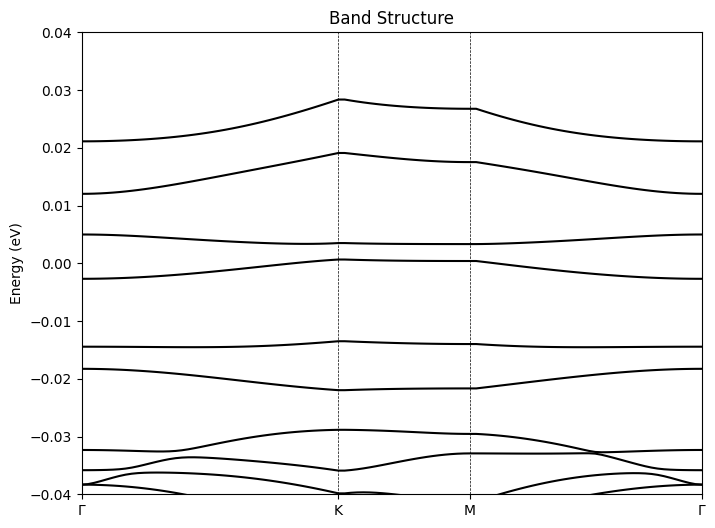

In [10]:
bs.plot(fig_params={"ylim": (-0.04, 0.04)}, plot_params={"color": "black"})

In [11]:
def compute_berry_curvature(kx, ky, dkx, dky, bnd_idx, H_calculator):
    # Get the wavefunction/eigenvectors (assuming we are interested in band number bnd_idx)
    _, psi = compute_eigenstuff(H_calculator, [[kx, ky]])
    _, psi_dkx = compute_eigenstuff(H_calculator, [[kx + dkx, ky]])
    _, psi_dky = compute_eigenstuff(H_calculator, [[kx, ky + dky]])

    # Finite differences to approximate derivatives
    dpsi_dkx = (psi[0, :, bnd_idx] - psi_dkx[0, :, bnd_idx]) / dkx
    dpsi_dky = (psi[0, :, bnd_idx] - psi_dky[0, :, bnd_idx]) / dky

    return np.imag(np.vdot(dpsi_dkx, dpsi_dky) - np.vdot(dpsi_dky, dpsi_dkx))


# Function to compute Berry curvature using the logarithmic approach
def compute_berry_curvature_log(kx, ky, dkx, dky, bnd_idx, H_calculator):
    _, psi = compute_eigenstuff(H_calculator, [[kx, ky]])
    _, psi_right = compute_eigenstuff(H_calculator, [[kx + dkx, ky]])
    _, psi_up = compute_eigenstuff(H_calculator, [[kx, ky + dky]])
    _, psi_diag = compute_eigenstuff(H_calculator, [[kx + dkx, ky + dky]])

    psi = psi[0, :, bnd_idx]
    psi_right = psi_right[0, :, bnd_idx]
    psi_up = psi_up[0, :, bnd_idx]
    psi_diag = psi_diag[0, :, bnd_idx]

    # Overlaps (link variables)
    Ux = np.vdot(psi, psi_right)
    Uy = np.vdot(psi, psi_up)
    Ux_dagger = np.vdot(psi_up, psi_diag)
    Uy_dagger = np.vdot(psi_right, psi_diag)

    return np.imag(np.log(Ux * Uy * np.conj(Ux_dagger) * np.conj(Uy_dagger)))


# Compute Chern number by integrating Berry curvature over the Brillouin zone
def compute_chern_number(kx_vals, ky_vals, dkx, dky, bnd_idx, H_calculator):
    berry_flux = 0
    berry_flux_log = 0
    for kx in kx_vals:
        for ky in ky_vals:
            berry_flux += compute_berry_curvature(
                kx, ky, dkx, dky, bnd_idx, H_calculator
            )
            berry_flux_log += compute_berry_curvature_log(
                kx, ky, dkx, dky, bnd_idx, H_calculator
            )
    # Normalization by BZ area
    chern_number = berry_flux * dkx * dky / (2 * np.pi)
    chern_number_log = berry_flux_log * dkx * dky / (2 * np.pi)
    return chern_number, chern_number_log


# Constants for Brillouin zone grid
nkpts = 20  # Number of grid points along each direction

kx_vals = np.linspace(-np.pi, np.pi, nkpts)
ky_vals = np.linspace(-np.pi, np.pi, nkpts)

dkx = kx_vals[1] - kx_vals[0]
dky = ky_vals[1] - ky_vals[0]

H_calculator = model.H_total_K

bnd_idx = mid_band
chern, chern_log = compute_chern_number(
    kx_vals, ky_vals, dkx, dky, bnd_idx, H_calculator
)
print(f"Chern number: {chern}")
print(f"Chern number log: {chern_log}")

Chern number: 0.013831020675402263
Chern number log: -0.00012125311968689299
